Begin with a 10,000-patient cohort named "cohort_sample_10k", created in Google Cloud BigQuery. This cohort is constructed by joining the following tables: physionet-data.mimiciv_3_1_hosp.admissions, physionet-data.mimiciv_3_1_icu.icustays, physionet-data.mimiciv_note.discharge, and physionet-data.mimiciv_3_1_hosp.patients, using hadm_id as the key. The dataset is filtered to include only adult patients. 

# 1. Install & Import Required Libraries

In [ ]:
# English language model en_core_web_sm used by spaCy for: Tokenization, POS tagging, Lemmatization and Named Entity Recognition (NER)
#! python -m spacy download en_core_web_sm 
#! pip install scikit-learn
#!pip install textblob
# %pip install torch
# %pip install transformers
# %pip install wordcloud
# %pip install transformers umap-learn 

# Standard libraries
import os
import io
from tqdm import tqdm
from tqdm.auto import tqdm
import joblib
import dill
from __future__ import annotations
from pathlib import Path
from typing import List
import torch
from torch.utils.data import DataLoader, Dataset

# Data manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# machine learning
import sklearn

# NLP
import re
import string
import nltk
from nltk import pos_tag
from nltk import word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
# from textblob import TextBlob
from collections import Counter
import spacy
from spacy.tokens import Doc
from sklearn.feature_extraction.text import TfidfVectorizer
from transformers import AutoModel, AutoTokenizer

# Download required resources
nltk.download('stopwords') # for stopword lists
nltk.download('punkt',  force=True)
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('wordnet') # for lemmatization
nltk.download('averaged_perceptron_tagger') # for POS tagging
nltk.download('omw-1.4')

c:\Users\Sheng Miao\mimic_readmit_clinbert\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package stopwords to C:\Users\Sheng
[nltk_data]     Miao\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\Sheng
[nltk_data]     Miao\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.
[nltk_data] Downloading package punkt_tab to C:\Users\Sheng
[nltk_data]     Miao\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\Sheng Miao\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Download

True

# 2. Load Data

Define the Table and Load into DataFrame

In [2]:
path = "../data/cohort_sample_10k.csv"

df = pd.read_csv(path)

In [3]:
df.head()

,subject_id,hadm_id,stay_id,admittime,dischtime,intime,outtime,note_id,text
0,11637434,27963062,37311168,2146-08-31 20:42:00,2146-09-01 17:45:00,2146-08-31 23:41:00,2146-09-01 15:06:49,11637434-DS-37,\nName: ___ Unit No: ___...
1,17079153,24372950,38333970,2177-05-30 17:42:00,2177-06-10 14:50:00,2177-05-30 17:42:57,2177-06-02 19:50:13,17079153-DS-19,\nName: ___ Unit No: __...
2,13121870,27370800,35473613,2171-09-30 08:15:00,2171-10-17 02:00:00,2171-10-03 21:47:00,2171-10-17 13:49:36,13121870-DS-6,\nName: ___ Unit No: ___\n...
3,19568723,27472793,35350089,2179-11-19 17:13:00,2179-11-25 17:30:00,2179-11-19 19:53:51,2179-11-21 17:57:42,19568723-DS-11,\nName: ___ Unit No: ___\...
4,18107351,20694258,39573073,2186-09-02 03:05:00,2186-09-18 11:56:00,2186-09-02 04:10:00,2186-09-04 17:20:49,18107351-DS-10,\nName: ___ Unit No: __...


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   subject_id  10000 non-null  int64 
 1   hadm_id     10000 non-null  int64 
 2   stay_id     10000 non-null  int64 
 3   admittime   10000 non-null  object
 4   dischtime   10000 non-null  object
 5   intime      10000 non-null  object
 6   outtime     10000 non-null  object
 7   note_id     10000 non-null  object
 8   text        10000 non-null  object
dtypes: int64(3), object(6)
memory usage: 703.2+ KB


# 3. Structured Data EDA

## 3.1 Convert to datetime

In [5]:
df['admittime'] = pd.to_datetime(df['admittime'])
df['dischtime'] = pd.to_datetime(df['dischtime'])
df['intime'] = pd.to_datetime(df['intime'])
df['outtime'] = pd.to_datetime(df['outtime'])

## 3.2 Duration Feature Generation

In [6]:
df['length_of_icu_stay'] = df['outtime'] - df['intime']

In [7]:
df['admit_to_disch'] = df['dischtime'] - df['admittime']

In [8]:
df.head()

,subject_id,hadm_id,stay_id,admittime,dischtime,intime,outtime,note_id,text,length_of_icu_stay,admit_to_disch
0,11637434,27963062,37311168,2146-08-31 20:42:00,2146-09-01 17:45:00,2146-08-31 23:41:00,2146-09-01 15:06:49,11637434-DS-37,\nName: ___ Unit No: ___...,0 days 15:25:49,0 days 21:03:00
1,17079153,24372950,38333970,2177-05-30 17:42:00,2177-06-10 14:50:00,2177-05-30 17:42:57,2177-06-02 19:50:13,17079153-DS-19,\nName: ___ Unit No: __...,3 days 02:07:16,10 days 21:08:00
2,13121870,27370800,35473613,2171-09-30 08:15:00,2171-10-17 02:00:00,2171-10-03 21:47:00,2171-10-17 13:49:36,13121870-DS-6,\nName: ___ Unit No: ___\n...,13 days 16:02:36,16 days 17:45:00
3,19568723,27472793,35350089,2179-11-19 17:13:00,2179-11-25 17:30:00,2179-11-19 19:53:51,2179-11-21 17:57:42,19568723-DS-11,\nName: ___ Unit No: ___\...,1 days 22:03:51,6 days 00:17:00
4,18107351,20694258,39573073,2186-09-02 03:05:00,2186-09-18 11:56:00,2186-09-02 04:10:00,2186-09-04 17:20:49,18107351-DS-10,\nName: ___ Unit No: __...,2 days 13:10:49,16 days 08:51:00


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype          
---  ------              --------------  -----          
 0   subject_id          10000 non-null  int64          
 1   hadm_id             10000 non-null  int64          
 2   stay_id             10000 non-null  int64          
 3   admittime           10000 non-null  datetime64[ns] 
 4   dischtime           10000 non-null  datetime64[ns] 
 5   intime              10000 non-null  datetime64[ns] 
 6   outtime             10000 non-null  datetime64[ns] 
 7   note_id             10000 non-null  object         
 8   text                10000 non-null  object         
 9   length_of_icu_stay  10000 non-null  timedelta64[ns]
 10  admit_to_disch      10000 non-null  timedelta64[ns]
dtypes: datetime64[ns](4), int64(3), object(2), timedelta64[ns](2)
memory usage: 859.5+ KB


Plot distribution

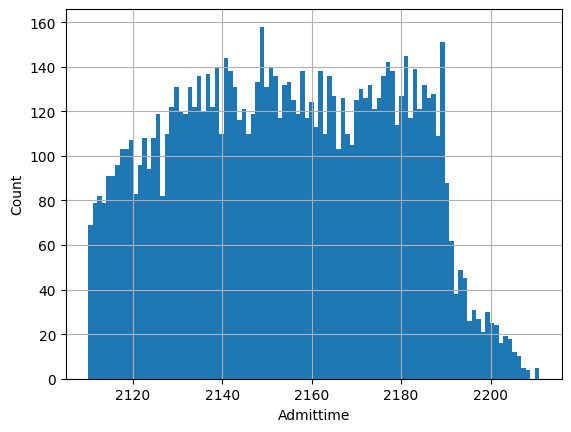

In [10]:
df.admittime.hist(bins=100)
plt.xlabel('Admittime')
plt.ylabel('Count')
plt.show()

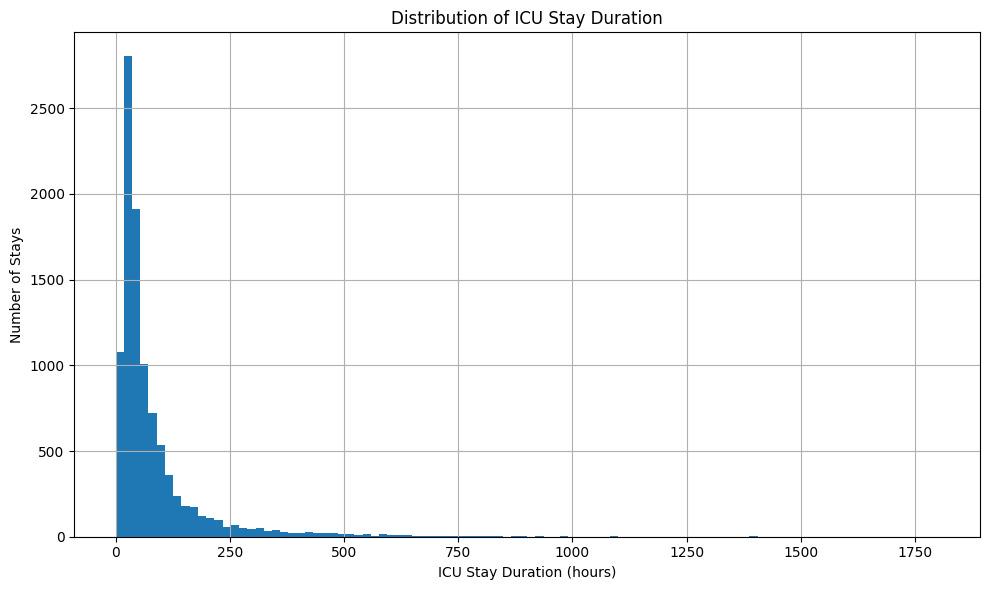

In [11]:
# Convert timedelta to hours (or use .dt.days for days)
df['length_of_icu_stay_hours'] = df['length_of_icu_stay'].dt.total_seconds() / 3600

plt.figure(figsize=(10, 6))
df['length_of_icu_stay_hours'].hist(bins=100)
plt.xlabel('ICU Stay Duration (hours)')
plt.ylabel('Number of Stays')
plt.title('Distribution of ICU Stay Duration')
plt.tight_layout()
plt.show()


In [6]:
print(len(df['length_of_icu_stay_hours']))

10000


In [9]:
df['length_of_icu_stay_hours'].isna().sum()

np.int64(0)

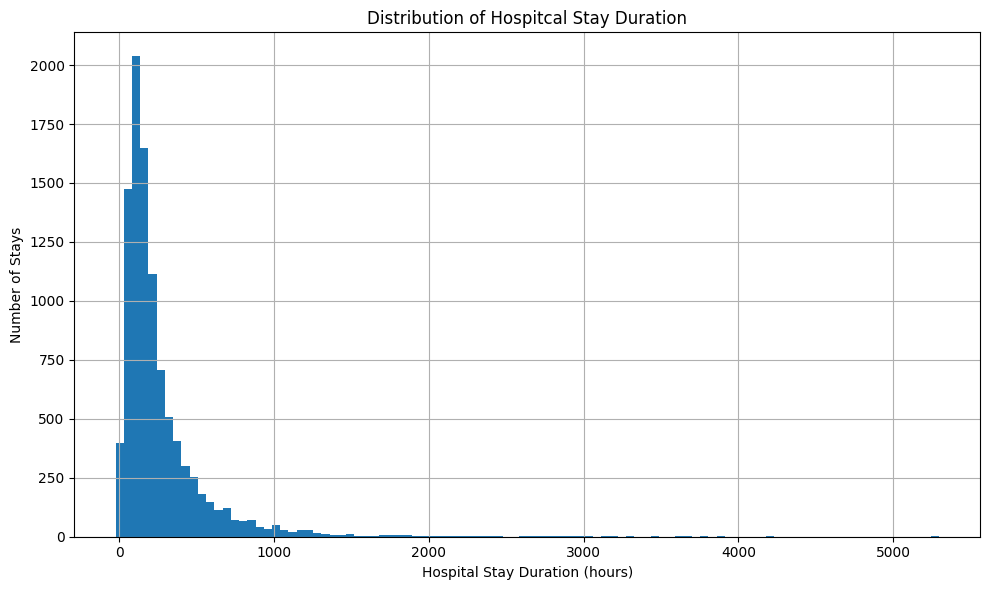

In [12]:
# Convert timedelta to hours (or use .dt.days for days)
df['admit_to_disch_hours'] = df['admit_to_disch'].dt.total_seconds() / 3600

plt.figure(figsize=(10, 6))
df['admit_to_disch_hours'].hist(bins=100)
plt.xlabel('Hospital Stay Duration (hours)')
plt.ylabel('Number of Stays')
plt.title('Distribution of Hospitcal Stay Duration')
plt.tight_layout()
plt.show()

In [10]:
df['admit_to_disch_hours'].isna().sum()

np.int64(0)

These plots show that the majority of hospital and ICU stays are relatively short, with most ICU stays lasting under 200 hours (~8 days) and hospital stays under 500 hours (~20 days). Both distributions are highly right-skewed, indicating that a small number of patients experienced significantly longer stays. The frequency drops sharply as the duration increases, with a few outliers extending well beyond 1,000 hours.

## 3.3 Create A Binary Target Variable for 30-day-Readmission 

I want to check: “Is there another admission for the same patient within 30 days after this discharge?”

In [13]:
# Sort data by subject and dischtime
df = df.sort_values(by=['subject_id', 'dischtime'])
df.iloc[:10, :8].head(10)

,subject_id,hadm_id,stay_id,admittime,dischtime,intime,outtime,note_id
7793,10000032,29079034,39553978,2180-07-23 12:35:00,2180-07-25 17:55:00,2180-07-23 14:00:00,2180-07-23 23:50:47,10000032-DS-23
774,10001725,25563031,31205490,2110-04-11 15:08:00,2110-04-14 15:00:00,2110-04-11 15:52:22,2110-04-12 23:59:56,10001725-DS-12
5154,10001884,26184834,37510196,2131-01-07 20:39:00,2131-01-20 05:15:00,2131-01-11 04:20:05,2131-01-20 08:27:30,10001884-DS-38
4525,10002428,28662225,33987268,2156-04-12 14:16:00,2156-04-29 16:26:00,2156-04-12 16:24:18,2156-04-17 15:57:08,10002428-DS-16
4128,10002428,23473524,35479615,2156-05-11 14:49:00,2156-05-22 14:16:00,2156-05-11 14:49:34,2156-05-22 14:16:46,10002428-DS-18
567,10002930,25922998,35629889,2198-04-17 19:38:00,2198-04-22 16:02:00,2198-04-17 21:24:00,2198-04-18 13:41:43,10002930-DS-12
8245,10004235,24181354,34100191,2196-02-24 14:38:00,2196-03-04 14:02:00,2196-02-24 17:07:00,2196-02-29 15:58:02,10004235-DS-21
499,10004401,23920883,32743332,2144-04-21 20:29:00,2144-05-01 13:00:00,2144-04-21 20:49:00,2144-05-01 13:53:03,10004401-DS-31
8551,10004422,21255400,32155744,2111-01-15 14:55:00,2111-01-25 15:00:00,2111-01-17 09:44:50,2111-01-23 18:18:46,10004422-DS-19
2779,10006580,24159665,38329661,2137-08-10 11:00:00,2137-08-15 13:25:00,2137-08-10 16:23:10,2137-08-11 13:56:56,10006580-DS-21


In [14]:
# Shift to get the next admission time for the same patient
df['next_admittime'] = df.groupby('subject_id')['admittime'].shift(-1)
# Calculate time delta from current discharge to next admission
df['days_to_next_admit'] = (df['next_admittime'] - df['dischtime']).dt.total_seconds() / (3600 * 24)

In [15]:
# Create binary target
# - 1 if readmitted within 30 days
# - 0 otherwise (including no readmission or readmission after 30 days)
df['readmit_30days'] = df['days_to_next_admit'].apply(lambda x: 1 if pd.notnull(x) and x <= 30 and x >= 0 else 0)
df[['readmit_30days']].head()

,readmit_30days
7793,0
774,0
5154,0
4525,1
4128,0


In [16]:
df['readmit_30days'].value_counts()

readmit_30days
0    9890
1     110
Name: count, dtype: int64

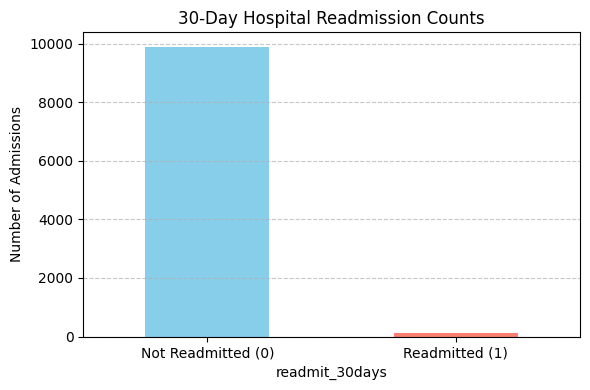

In [12]:
# Count the values
counts = df['readmit_30days'].value_counts().sort_index()

# Plot
plt.figure(figsize=(6, 4))
counts.plot(kind='bar', color=['skyblue', 'salmon'])

# Labels and title
plt.xticks(ticks=[0, 1], labels=['Not Readmitted (0)', 'Readmitted (1)'], rotation=0)
plt.ylabel('Number of Admissions')
plt.title('30-Day Hospital Readmission Counts')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

plt.show()

In [17]:
print(df.isnull().sum())

subject_id                     0
hadm_id                        0
stay_id                        0
admittime                      0
dischtime                      0
intime                         0
outtime                        0
note_id                        0
text                           0
length_of_icu_stay             0
admit_to_disch                 0
length_of_icu_stay_hours       0
admit_to_disch_hours           0
next_admittime              9238
days_to_next_admit          9238
readmit_30days                 0
dtype: int64


# 4. Clinical Note Data EDA

## 4.1 Basic statistics

In [18]:
df['note_length'] = df['text'].apply(len)
df['word_count'] = df['text'].apply(lambda x: len(x.split()))

In [19]:
df[['note_length','word_count']].head()

,note_length,word_count
7793,10608,1633
774,12107,1828
5154,9303,1371
4525,18547,2768
4128,17123,2537


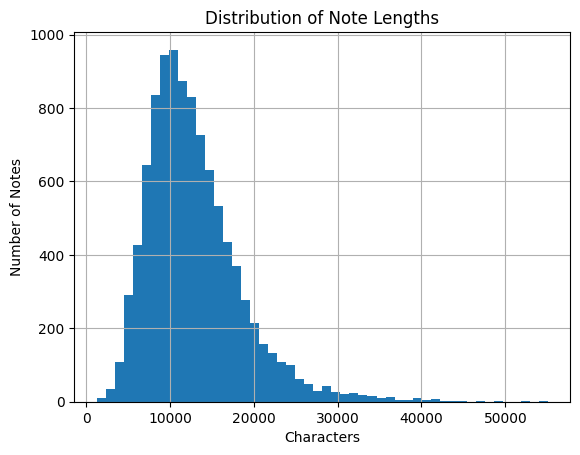

In [20]:
# Histogram
df['note_length'].hist(bins=50)
plt.title("Distribution of Note Lengths")
plt.xlabel("Characters")
plt.ylabel("Number of Notes")
plt.show()

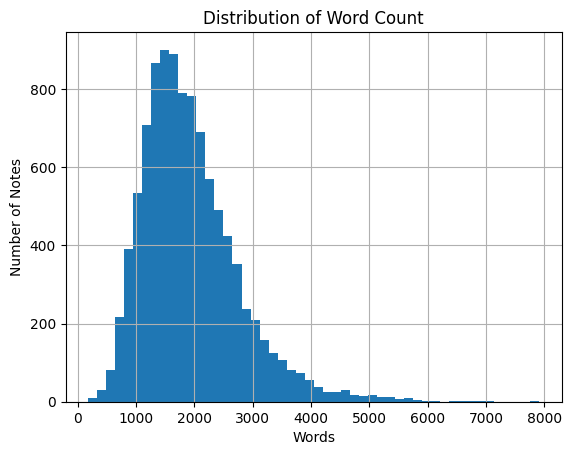

In [21]:
# Histogram
df['word_count'].hist(bins=50)
plt.title("Distribution of Word Count")
plt.xlabel("Words")
plt.ylabel("Number of Notes")
plt.show()

## 4.2 Check for duplicates

In [22]:
# check for duplicate discharge notes for the same patient (subject_id) and hospital admission (hadm_id).
df.duplicated(subset=['subject_id', 'hadm_id', 'text']).sum()


np.int64(146)

In [23]:
dup_df = df[df.duplicated(subset=['subject_id', 'hadm_id', 'text'], keep=False)]
dup_df = dup_df.sort_values(by=['subject_id', 'hadm_id'])
dup_df.head()

,subject_id,hadm_id,stay_id,admittime,dischtime,intime,outtime,note_id,text,length_of_icu_stay,admit_to_disch,length_of_icu_stay_hours,admit_to_disch_hours,next_admittime,days_to_next_admit,readmit_30days,note_length,word_count
6181,10097612,21981172,38728878,2159-11-11 23:17:00,2159-11-27 17:30:00,2159-11-21 16:53:01,2159-11-23 21:31:07,10097612-DS-18,\nName: ___ Unit No: __...,2 days 04:38:06,15 days 18:13:00,52.635000,378.216667,2159-11-11 23:17:00,-15.759028,0,11669,1808
8784,10097612,21981172,37784017,2159-11-11 23:17:00,2159-11-27 17:30:00,2159-11-15 10:14:06,2159-11-16 18:04:54,10097612-DS-18,\nName: ___ Unit No: __...,1 days 07:50:48,15 days 18:13:00,31.846667,378.216667,NaT,NaN,0,11669,1808
91,10098215,21701015,36587540,2118-01-10 03:42:00,2118-02-13 19:00:00,2118-01-29 08:34:28,2118-01-31 21:26:32,10098215-DS-17,\nName: ___ Unit No: ___...,2 days 12:52:04,34 days 15:18:00,60.867778,831.300000,2118-01-10 03:42:00,-34.637500,0,21988,3289
7703,10098215,21701015,30598744,2118-01-10 03:42:00,2118-02-13 19:00:00,2118-01-10 12:52:08,2118-01-14 18:43:50,10098215-DS-17,\nName: ___ Unit No: ___...,4 days 05:51:42,34 days 15:18:00,101.861667,831.300000,2118-05-03 23:07:00,79.171528,0,21988,3289
5616,10108435,22063907,39659709,2184-03-04 21:58:00,2184-03-26 21:00:00,2184-03-04 23:56:00,2184-03-09 01:24:56,10108435-DS-32,\nName: ___ ___ No: ___\n \nAdmis...,4 days 01:28:56,21 days 23:02:00,97.482222,527.033333,2184-03-04 21:58:00,-21.959722,0,10423,1600


In [24]:
# for (subject, hadm), group in dup_df.groupby(['subject_id', 'hadm_id']):
#     print(f"\n🔹 subject_id: {subject}, hadm_id: {hadm}, count: {len(group)}")
#     display(group)

After run the code cell above to inspect the duplicates within each group, it appears that the duplicated records correspond to different ICU stay_ids for the same patient within the same hadm_id. Most groups have two distinct stay_ids, while a few have three. 

## 4.3 Frequent words or terms

In [25]:
# Loads a list of common English stopwords (e.g., "the", "is", "and") using nltk and converts it to a set for faster lookup
# Base stopwords
stop_words = set(stopwords.words('english'))

def tokenize(text):
    # Lowercase and tokenize using regex
    tokens = re.findall(r'\b\w+\b', text.lower())
    return [word for word in tokens if word not in stop_words and word not in string.punctuation]

# .explode() flattens the list into a single column of words, one per row — so now all_words is a Series of individual words across all notes.
all_words = df['text'].apply(tokenize).explode() 

# Count the frequency of each word in the exploded Series using Counter, and returns the 20 most common words as a list of tuples (word, count)
Counter(all_words).most_common(20)

[('___', 725513),
 ('1', 200562),
 ('mg', 178274),
 ('2', 165674),
 ('po', 146863),
 ('blood', 137494),
 ('0', 125808),
 ('3', 122982),
 ('5', 113304),
 ('4', 105429),
 ('daily', 104594),
 ('patient', 97496),
 ('discharge', 92316),
 ('left', 82974),
 ('tablet', 74974),
 ('6', 73352),
 ('8', 72465),
 ('right', 72057),
 ('7', 70421),
 ('history', 64437)]

'mg', 'tablet', and numbers like '1', '2' are common — expected in medication instructions. 'patient', 'discharge', 'history' are frequent medical terms in discharge summaries.
To improve quality:
1. add '__', digits ('1', '2'...), and 'mg', 'tablet' to a custom stopword list since they aren't meaningful for modeling, 
2. apply POS-aware lemmatization (reduce "patients" to "patient", "was" to "be") for better generalization and accuracy.

# 5. Text Processing (Cleaning, Tokenization and Lemmatization)

## 5.1 NLTK Based Pipeline (in python loops)

In [26]:
# # Step 1: Stopword setup
# # Base stopwords
# stop_words = set(stopwords.words('english'))

# # Add custom stopwords
# custom_stopwords = {
#     '__', '___', '____', 'mg', 'tablet', 'po', 'x', 'bid', 'prn' 
# }

# # Merge with base stopwords
# stop_words.update(custom_stopwords)

# # Step 2: POS (part-of-speech) tag mapping for WordNetLemmatizer
# def get_wordnet_pos(treebank_tag):
#     """The POS tags returned by nltk.pos_tag() (called Treebank tags) are different from the format expected by WordNetLemmatizer, 
#     this function is to convert Treebank POS tags to the format WordNet understands """
#     """Map NLTK POS tag to WordNet POS tag."""
#     if treebank_tag.startswith('J'):
#         return wordnet.ADJ
#     elif treebank_tag.startswith('V'):
#         return wordnet.VERB
#     elif treebank_tag.startswith('N'):
#         return wordnet.NOUN
#     elif treebank_tag.startswith('R'):
#         return wordnet.ADV
#     else:
#         return wordnet.NOUN  # Default to noun

# # Lemmatizer
# lemmatizer = WordNetLemmatizer()

# # Step 3: Tokenizer function with POS-based lemmatization
# def clean_tokenize(text):
#     # Lowercase and tokenize
#     tokens = word_tokenize(text.lower())
#     # POS tagging
#     pos_tags = pos_tag(tokens) #
    
#     # Lemmatize with POS, remove stopwords/punctuation
#     clean_tokens = [
#         lemmatizer.lemmatize(word, get_wordnet_pos(pos))
#         for word, pos in pos_tags
#         if word not in stop_words and word not in string.punctuation and not word.isdigit()
#     ]
#     return clean_tokens

# # Step 4: Apply with progress bar, Apply to dataframe
# tqdm.pandas()
# # df['nltk_clean_token'] = df['text'].progress_apply(clean_tokenize)

Using nltk.pos_tag() on full-doc tokens without batching will silently drop a large portion of my data.

## 5.2 NLTK Based Pipeline (using TextBlob)

Use TextBlob as a drop-in NLP engine (it wraps NLTK + lemmatization + POS-tagging with speed gains), while preserving NLTK stopword logic:
- TextBlob internally uses nltk.pos_tag and WordNet lemmatizer but batches efficiently.
- Reduces overhead from manually calling pos_tag and looping through every token.
- Still allows stopword + digit + punctuation filtering with full control.

In [27]:
# # Step 1: Setup stopwords
# stop_words = set(stopwords.words('english')).union({
#     '__', '___', '____', 'mg', 'tablet', 'po', 'x', 'bid', 'prn'
# })

# # Step 2: Efficient cleaner using TextBlob's built-in POS-tagging and lemmatization
# def fast_clean_tokenize(text):
#     blob = TextBlob(text.lower())
#     return [
#         word.lemmatize()
#         for word, pos in blob.tags
#         if word not in stop_words and word not in string.punctuation and not word.isdigit()
#     ]

# # Step 3: Apply to DataFrame
# tqdm.pandas()
# # df['nltk_clean_token'] = df['text'].progress_apply(fast_clean_tokenize)

Compared to the NLTK Based Pipeline (in python loops), using TextBlob supposed to be faster, because:
- It wraps everything into a compiled, streamlined pipeline.
- It can internally cache and batch some operations.
- Less Python-side looping — more C-optimized backend from NLTK.

However, it still need as much as about 1hr. 

## 5.3 spaCy-based pipeline
- Uses compiled Cython code under the hood
- Runs tokenization, POS tagging, and lemmatization in a single pass
- Allows disabling unused components (e.g., parser, ner) to speed up further

In [28]:
# # Step 1: Install dependencies (once)
# #! python -m spacy download en_core_web_sm

# # Step 2: Optimized Pipeline Using spaCy
# # Load spaCy model
# nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])

# # Define stopwords and digits to remove
# nltk_stopwords = set(stopwords.words('english'))
# custom_stopwords = nltk_stopwords.union({'___', '__', '____', 'mg', 'tablet', 'po', 'x', 'bid', 'prn'})
# punctuations = set(string.punctuation)

# # Tokenizer + POS Lemmatizer
# def spacy_clean_tokenize(text):
#     doc = nlp(text.lower())
#     return [
#         token.lemma_
#         for token in doc
#         if token.is_alpha                            # keep only alphabetic tokens
#         and token.text not in custom_stopwords       # remove stopwords + custom
#         and not token.text.isdigit()                 # remove numbers
#     ]

# # Step 3: Apply with progress bar
# tqdm.pandas()
# df['spacy_clean_token'] = df['text'].progress_apply(spacy_clean_tokenize)

It took 31min.

## 5.4 spaCy Batch Processing Pipeline
process multiple notes in batches — much faster than applying function one note at a time.
Why this is fastest:
- nlp.pipe() processes batches of texts internally with compiled code
- avoid Python-level function calls per row (big slowdown in pandas)
- spaCy is Vectorized
- spaCy uses CPU cores efficiently
- tqdm still tracks without slowing execution

In [29]:
# def spacy_tokenizer_pipe(texts, batch_size=200):
#     """Yields lemmas lists for each doc"""
#     results = []
#     for doc in tqdm(nlp.pipe(texts, batch_size=batch_size), total=len(texts)):
#         lemmas = [
#             token.lemma_.lower() for token in doc
#             if token.text.lower().isalpha()
#             and token.text.lower() not in custom_stopwords
#             and not token.text.isdigit()
#         ]
#         results.append(lemmas)
#     return results

# # Load spaCy with only what we need
# nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])

# # Prepare stopwords and punctuation
# nltk_stopwords = set(stopwords.words('english'))
# custom_stopwords = nltk_stopwords.union({'__', '___', '____', 'mg', 'tablet', 'po', 'x', 'bid', 'prn'})
# punctuations = set(string.punctuation)

# df['spacy_lemmas'] = spacy_tokenizer_pipe(df['text'], batch_size=200)

It took 35min. 

## 5.5 Advanced spaCy Batch Processing Pipeline

leveraging:
-   Batch + parallel processing
-   convert the spaCy Doc object into a Numpy array of integer hash ID of the lemmatized form of each token

In [30]:
import sys, pathlib, subprocess, json, os
print("sys.prefix =", sys.prefix)


sys.prefix = c:\Users\Sheng Miao\mimic_readmit_clinbert\.venv


In [31]:
# 1. Let SpaCy do more work in C
# disable all but the tokenizer+lemmatizer
nlp = spacy.load("en_core_web_sm", disable=["parser","ner"])

# Prepare stopwords and punctuation
nltk_stopwords = set(stopwords.words('english'))
custom_stopwords = nltk_stopwords.union({'__', '___', '____', 'mg', 'tablet', 'po', 'x', 'bid', 'prn'})
punctuations = set(string.punctuation)

results = []

for doc in tqdm(nlp.pipe(df['text'], batch_size=200, n_process=1), total=len(df['text'])):
    
    # vectorized C call to get all lemmas in one shot
    lemmas_ids = doc.to_array("LEMMA")
    # filter and lowercase in bulk
    lemma_strings = [nlp.vocab.strings[lemma_id].lower() for lemma_id in lemmas_ids]
    filtered_lemmas = [lemma for lemma in lemma_strings
              if lemma.isalpha() and lemma not in custom_stopwords]
    
    results.append(filtered_lemmas)

df['advanced_spacy_lemmas'] = results


100%|██████████| 10000/10000 [28:53<00:00,  5.77it/s] 


It took 29min. For CPU-only, single-core, full lemmatization of clinical or long texts, the speed is reasonable. Especially because:
- spaCy loads full vocab
- Lemmatization requires morphological analysis
- I'm filtering, converting to strings, lowercasing, and checking stopwords

## 5.6 Choose the best pipeline

In [32]:
print(df.columns)

Index(['subject_id', 'hadm_id', 'stay_id', 'admittime', 'dischtime', 'intime',
       'outtime', 'note_id', 'text', 'length_of_icu_stay', 'admit_to_disch',
       'length_of_icu_stay_hours', 'admit_to_disch_hours', 'next_admittime',
       'days_to_next_admit', 'readmit_30days', 'note_length', 'word_count',
       'advanced_spacy_lemmas'],
      dtype='object')


In [33]:
# df['spacy_lemmas_n'] = df['spacy_lemmas'].apply(len)
df['advanced_spacy_lemmas_n'] = df['advanced_spacy_lemmas'].apply(len)

In [5]:
df['advanced_spacy_lemmas_n'].describe()

count    10000.000000
mean      1109.351600
std        487.464824
min        110.000000
25%        775.000000
50%       1023.000000
75%       1347.000000
max       4802.000000
Name: advanced_spacy_lemmas_n, dtype: float64

In [34]:
# df[['spacy_lemmas_n', 'advanced_spacy_lemmas_n']].head(10)

Comparasion of two spaCy-based batch processing pipeline with or without integer hash ID conversion, they produces very close token count per text document after cleaning, tokenization, and lemmatization. 

In [35]:
# def pipeline_specific_tokens(row):
#     set1, set2 = set(row['spacy_lemmas']), set(row['advanced_spacy_lemmas'])
    
#     shared = set1 & set2  # Tokens shared by all three
    
#     return {
#         'unique_spacy': list(set1 - shared),
#         'unique_adv_spacy': list(set2 - shared),
#     }

# # Apply the function row-wise
# unique_tokens_df = df.iloc[:10].apply(pipeline_specific_tokens, axis=1, result_type='expand')

In [36]:
# # Set display options to avoid truncation
# pd.set_option('display.max_colwidth', None)       # No limit on column content width
# pd.set_option('display.width', 0)                 # Auto-detect the width of the display
# pd.set_option('display.max_columns', None)        # Show all columns

In [37]:
# display(unique_tokens_df)

Based on the unique lemma comparison between the standard and advanced spaCy pipelines, I observed that lemmas such as ‘do’ and ‘tablet’ appeared only in the standard pipeline but were excluded by the advanced one. These terms are either common function words or generic clinical references with limited predictive value for 30-day hospital readmission.Therefore, I selected the advanced lemmatization pipeline for downstream modeling.

## 5.7 Lemma-based Visualizations

### 5.7.1 Bar Plot of Most Frequent Lemmas

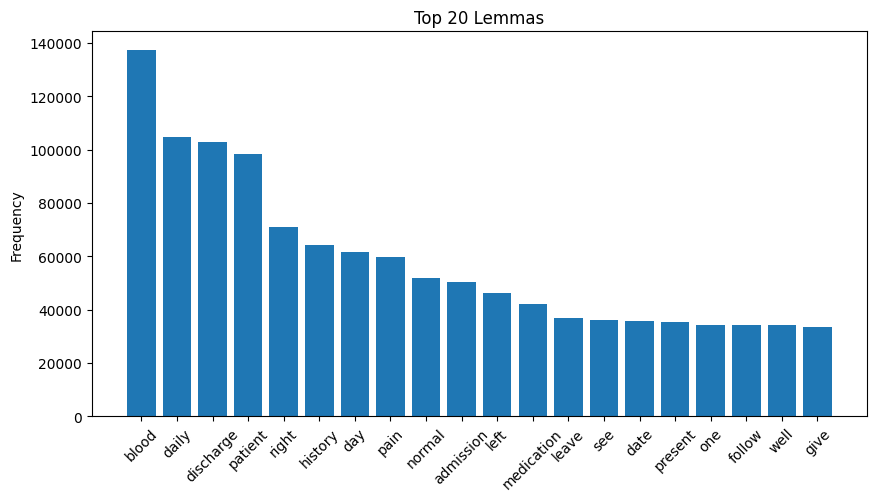

In [13]:
from collections import Counter
import matplotlib.pyplot as plt

all_lemmas = df['advanced_spacy_lemmas'].explode()  
freq = Counter(all_lemmas)
common = freq.most_common(20)

words, counts = zip(*common)
plt.figure(figsize=(10, 5))
plt.bar(words, counts)
plt.xticks(rotation=45)
plt.title("Top 20 Lemmas")
plt.ylabel("Frequency")
plt.show()


### 5.7.2 Word Cloud

In [ ]:
# %pip install wordcloud

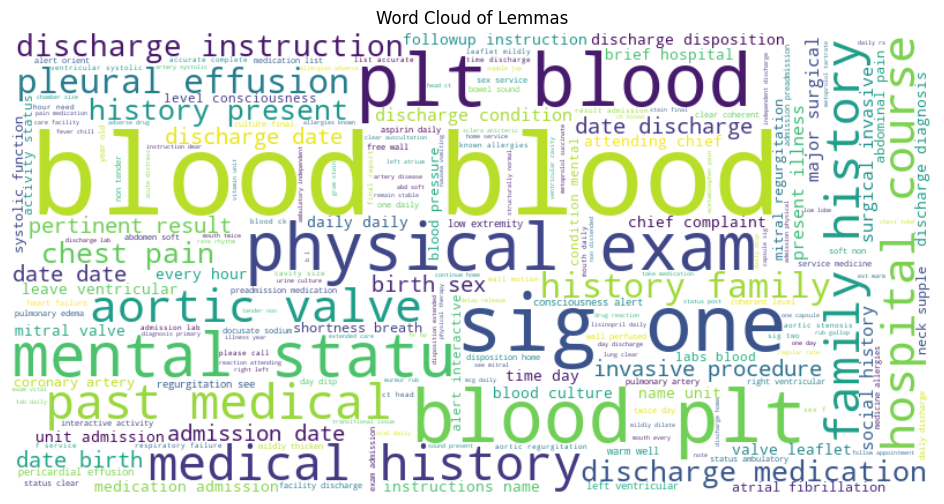

In [16]:
from wordcloud import WordCloud

text = " ".join(all_lemmas)
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud of Lemmas")
plt.show()


# 6. Text Feature Extraction

## 6.1 Extract TF-IDF vectors from selected lemma column (e.g., 'advanced_spacy_lemmas')

In [38]:
# 1. Join token lists into strings (required by TfidfVectorizer)
df['lemma_text'] = df['advanced_spacy_lemmas'].apply(lambda lemmas: ' '.join(lemmas))

# 2. Initialize the TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(
    lowercase=False,   # Tokens are already cleaned
    # Out of all the tokens (or n-grams) across the entire corpus, keep only the top 1,000 most frequent ones (by TF-IDF score).
    max_features=2000, # Adjust as needed
    ngram_range=(1, 2) # Unigrams and bigrams
)

# 3. Fit and transform
X_tfidf = tfidf_vectorizer.fit_transform(df['lemma_text'])

# 4. Convert to DataFrame for inspection

tfidf_df = pd.DataFrame(X_tfidf.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

tfidf_df.shape

(10000, 2000)

In [39]:
tfidf_df.head()

,ab,abd,abd soft,abdomen,abdomen pelvis,abdomen soft,abdominal,abdominal pain,able,abnormal,...,year,year ago,year old,yeast,yeast none,yellow,yes,yesterday,yo,zosyn
0,0.0,0.015593,0.020919,0.000000,0.0,0.000000,0.015978,0.019528,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.00000,0.000000,0.0,0.058098,0.0,0.000000
1,0.0,0.015959,0.021410,0.026159,0.0,0.035686,0.016353,0.019986,0.017096,0.023449,...,0.000000,0.0,0.000000,0.000000,0.00000,0.000000,0.0,0.029731,0.0,0.000000
2,0.0,0.000000,0.000000,0.017142,0.0,0.000000,0.000000,0.000000,0.022407,0.000000,...,0.000000,0.0,0.000000,0.000000,0.00000,0.000000,0.0,0.000000,0.0,0.000000
3,0.0,0.032521,0.000000,0.017768,0.0,0.000000,0.088864,0.040727,0.000000,0.000000,...,0.019543,0.0,0.024009,0.017283,0.00000,0.000000,0.0,0.000000,0.0,0.000000
4,0.0,0.000000,0.000000,0.009932,0.0,0.013550,0.000000,0.000000,0.012983,0.000000,...,0.021849,0.0,0.026841,0.077289,0.02183,0.020616,0.0,0.000000,0.0,0.084001


In [40]:
# Merge TF-IDF Features to Structured Data
tfidf_combined = pd.concat([df.reset_index(drop=True), tfidf_df.reset_index(drop=True)], axis=1)

## 6.2 Transformer-Based Word Embedding (ClinicalBERT)

In [41]:
# --- Make the project root importable ---------------------------------
import sys, pathlib

package_parent = pathlib.Path.cwd().parents[1]          # two levels up from notebooks/
if str(package_parent) not in sys.path:             # keep sys.path tidy
    sys.path.insert(0, str(package_parent))

In [42]:
# Assume df already has a "lemmas" column
from mimic_readmit_clinbert.utils.embeddings import add_clinbert_embeddings

clinbert_df = add_clinbert_embeddings(df, text_col="advanced_spacy_lemmas", batch_size=32)
print(clinbert_df.shape)  # original cols + 768 embedding cols

ClinicalBERT: 100%|██████████| 10000/10000 [50:12<00:00,  3.32it/s]


(10000, 768)


It took 50min.

In [43]:
df.lemma_text.head()

7793    name unit admission date discharge date date b...
774     name unit admission date discharge date date b...
5154    name unit admission date discharge date date b...
4525    name admission date discharge date date birth ...
4128    name admission date discharge date date birth ...
Name: lemma_text, dtype: object

visualize ClinicalBERT (or any BERT) embeddings using t-SNE or UMAP

In [ ]:
# %pip install transformers umap-learn 


   ---------------------------------------- 0/2 [pynndescent]
   -------------------- ------------------- 1/2 [umap-learn]
   ---------------------------------------- 2/2 [umap-learn]

Note: you may need to restart the kernel to use updated packages.


In [ ]:
# from transformers import AutoTokenizer, AutoModel
# from sklearn.manifold import TSNE
# import umap

# # ─────────────── 1. Load ClinicalBERT Model ───────────────
# MODEL_NAME = "emilyalsentzer/Bio_ClinicalBERT"
# tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
# model = AutoModel.from_pretrained(MODEL_NAME)
# model.eval().cpu()  # use .cuda() if GPU

# # ─────────────── 2. Define BERT Embedding Function ───────────────
# @torch.no_grad()
# def get_cls_embeddings(texts, max_len=128):
#     """Return CLS token embeddings from BERT for a list of texts."""
#     inputs = tokenizer(
#         texts, 
#         padding=True, 
#         truncation=True, 
#         max_length=max_len, 
#         return_tensors="pt"
#     )
#     inputs = {k: v.cuda() for k, v in inputs.items()}  # remove if using CPU
#     outputs = model(**inputs)
#     cls_embeddings = outputs.last_hidden_state[:, 0, :]  # CLS token
#     return cls_embeddings.cpu().numpy()

# # ─────────────── 3. Sample & Embed Text ───────────────
# # Convert lemmas into strings (if not already)
# df["lemmas_str"] = df["lemmas"].apply(lambda x: " ".join(x) if isinstance(x, list) else x)
# df_sample = df.sample(n=500, random_state=42)  # keep it small for t-SNE

# texts = df_sample["lemmas_str"].tolist()
# labels = df_sample["readmit_30days"].tolist()

# embeddings = get_cls_embeddings(texts)

# # ─────────────── 4A. t-SNE ───────────────
# tsne = TSNE(n_components=2, perplexity=30, random_state=42)
# X_tsne = tsne.fit_transform(embeddings)

# plt.figure(figsize=(8, 6))
# sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=labels, palette=["skyblue", "salmon"])
# plt.title("t-SNE of ClinicalBERT Embeddings")
# plt.xlabel("Component 1")
# plt.ylabel("Component 2")
# plt.legend(title="Readmitted")
# plt.grid(True)
# plt.tight_layout()
# plt.show()

# # ─────────────── 4B. UMAP ───────────────
# reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, metric='cosine', random_state=42)
# X_umap = reducer.fit_transform(embeddings)

# plt.figure(figsize=(8, 6))
# sns.scatterplot(x=X_umap[:, 0], y=X_umap[:, 1], hue=labels, palette=["skyblue", "salmon"])
# plt.title("UMAP of ClinicalBERT Embeddings")
# plt.xlabel("UMAP-1")
# plt.ylabel("UMAP-2")
# plt.legend(title="Readmitted")
# plt.grid(True)
# plt.tight_layout()
# plt.show()


In [44]:
# Merge ClinicalBERT embedding to Structured Data
clinbert_combined = pd.concat([df.reset_index(drop=True), clinbert_df.reset_index(drop=True)], axis=1)

In [45]:
clinbert_combined.lemma_text.head()

0    name unit admission date discharge date date b...
1    name unit admission date discharge date date b...
2    name unit admission date discharge date date b...
3    name admission date discharge date date birth ...
4    name admission date discharge date date birth ...
Name: lemma_text, dtype: object

In [46]:
# Merge fuse structured variables + TF-IDF features + transformer embeddings
tfidf_clinbert = pd.concat([tfidf_combined.reset_index(drop=True), clinbert_df.reset_index(drop=True)], axis=1)

# 7. Save Dataset and Variables

Save df DataFrame into csv file

In [47]:
from pathlib import Path

root_dir = Path.cwd().parent          # notebooks → mimic_readmit_clinbert
data_dir = root_dir / "data"
data_dir.mkdir(exist_ok=True)         # create folder if missing

df.to_csv               (data_dir / "cleaned_lemmas_1.csv",    index=False)
tfidf_df.to_csv         (data_dir / "tfidf_1.csv",             index=False)
tfidf_combined.to_csv   (data_dir / "tfidf_combined_1.csv",    index=False)
clinbert_df.to_csv      (data_dir / "clinbert_df_1.csv",       index=False)
clinbert_combined.to_csv(data_dir / "clinbert_combined_1.csv", index=False)
tfidf_clinbert.to_csv   (data_dir / "tfidf_clinbert_1.csv",    index=False)


Structured EHR variables, TF-IDF on raw or lemmatised notes, and ClinicalBERT CLS/pooled embeddings, the three channels emphasise different statistical signals, stacking them side-by-side (early fusion) or training separate models and ensemble-combining outputs (late fusion) often yields small-to-moderate AUC gains in clinical-NLP papers.

Save only selected important variables

In [48]:
saved_dir = root_dir / "saved"
saved_dir.mkdir(exist_ok=True)         # create folder if missing

EDA_session = {
    'df': df,                        
    'tfidf_df': tfidf_df,
    'tfidf_combined': tfidf_combined, 
    'tfidf_vectorizer': tfidf_vectorizer,
    'clinbert_df':clinbert_df,
    'clinbert_combined': clinbert_combined,
    'tfidf_clinbert':tfidf_clinbert
}

joblib.dump(EDA_session, saved_dir/'EDA_session_1.joblib')

['c:\\Users\\Sheng Miao\\mimic_readmit_clinbert\\saved\\EDA_session_1.joblib']

Resuming work

In [4]:
root_dir = Path.cwd().parent
saved_dir = root_dir / "saved"
saved_dir.mkdir(exist_ok=True)         # create folder if missing

session_data = joblib.load(saved_dir/"EDA_session_1.joblib")
df = session_data['df']
tfidf_df = session_data['tfidf_df']
tfidf_combined = session_data['tfidf_combined']
tfidf_vectorizer = session_data['tfidf_vectorizer']
clinbert_df = session_data['clinbert_df']
clinbert_combined = session_data['clinbert_combined']
tfidf_clinbert = session_data['tfidf_clinbert']